In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import pickle

In [4]:
# with open('./pkl_files/enchanced/validation/en_val_data.pkl', 'rb') as f:
#     val_img_arr = pickle.load(f)
# with open('./pkl_files/enchanced/validation/en_val_data_age.pkl', 'rb') as f:
#     val_bone_age_arr = pickle.load(f)
# with open('./pkl_files/enchanced/validation/en_val_data_gender.pkl', 'rb') as f:
#     val_gender_arr = pickle.load(f)
# 
# images_arr_val = np.array(val_img_arr)
# bone_age_val = np.array(val_bone_age_arr)
# gender_val = np.array(val_gender_arr)

In [5]:
with open('./pkl_files/enchanced/training/en_train_data.pkl', 'rb') as f:
    train_img_arr = pickle.load(f)
with open('./pkl_files/enchanced/training/en_train_data_age.pkl', 'rb') as f:
    train_bone_age_arr = pickle.load(f)
with open('./pkl_files/enchanced/training/en_train_data_gender.pkl', 'rb') as f:
    train_gender_arr = pickle.load(f)

images_arr_train = np.array(train_img_arr)
bone_age_train = np.array(train_bone_age_arr)
gender_train = np.array(train_gender_arr)

In [7]:
X_train = images_arr_train
#X_val = images_arr_val
y_train = bone_age_train
#y_val = bone_age_val
print("Training set: (",len(X_train),", ",len(y_train),")\n")
#print("Validation set: (",len(X_val),", ",len(y_val),")\n")

Training set: ( 12611 ,  12611 )


In [12]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.utils import plot_model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
from keras.applications.resnet import ResNet50
import keras
from keras.applications.inception_v3 import preprocess_input

In [33]:
def build_regression_model():
    base_model_carpal = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model_metacarpal = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    gender_input = Input(shape=(1,), name='gender_input')
    
    for layer in base_model_carpal.layers:
        layer._name = 'carpal_' + layer.name
    for layer in base_model_metacarpal.layers:
        layer._name = 'metacarpal_' + layer.name

    for layer in base_model_carpal.layers:
        layer.trainable = False
    for layer in base_model_metacarpal.layers:
        layer.trainable = False
        
    x1 = Flatten()(base_model_carpal.output)
    x2 = Flatten()(base_model_metacarpal.output)

    gender_weight = tf.Variable(initial_value=1.0, trainable=True, name='gender_weight')
    gender_input_weighted = tf.multiply(gender_input, gender_weight)
    x = Concatenate()([x1, x2, gender_input_weighted])

    x = Dense(512, activation='relu')(x)
    x= Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    
    predictions = Dense(1, activation='relu')(x) 

    model = Model(inputs=(base_model_carpal.input, base_model_metacarpal.input, gender_input), outputs=predictions)

    return model

In [15]:
#model.summary()

In [10]:
model = build_regression_model()

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 carpal_input_3 (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 metacarpal_input_4 (InputLayer  [(None, 224, 224, 3  0          []                               
 )                              )]                                                                
                                                                                                  
 carpal_conv1_pad (ZeroPadding2  (None, 230, 230, 3)  0          ['carpal_input_3[0][0]']         
 D)                                                                                         

# For metacarpal

In [16]:
import os
from PIL import Image

metacarpal_image_data = []

for index, image_name in enumerate(y_train):
    image_path = os.path.join('./cropped_images/metacarpal/training/',str(index)+'.jpg')
    img = Image.open(image_path)
    img_array = np.array(img)
    metacarpal_image_data.append(img_array)

In [17]:
carpal_image_data = []

for index, image_name in enumerate(y_train):
    image_path = os.path.join('./cropped_images/carpal/training/',str(index)+'.jpg')
    img = Image.open(image_path)
    img_array = np.array(img)
    carpal_image_data.append(img_array)

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])

In [35]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger

filepath = "saved_models/resnet/weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='accuracy',verbose=1,save_best_only=True,mode ='min')
early_stop = EarlyStopping(monitor='mae',patience=5,verbose=1)
log_csv = CSVLogger('./csv_files/resnet/test_train_1.csv',separator=',', append=False)

callbacks_list = [log_csv]

In [20]:
metacarpal_image_data = np.array(metacarpal_image_data)
carpal_image_data = np.array(carpal_image_data)

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy', 'mae'])

In [34]:
model = build_regression_model()

In [39]:
history = model.fit(
    (metacarpal_image_data[:200],carpal_image_data[:200], gender_train[:200]),y_train[:200],
    epochs=10,
    batch_size=32,
    validation_data=((metacarpal_image_data[200:250],carpal_image_data[200:250], gender_train[200:250]), y_train[200:250]),
    callbacks=callbacks_list
)

Epoch 1/10
7/7 [==============================] - 3s 374ms/step - loss: 1252.6748 - accuracy: 0.0000e+00 - mae: 27.1967 - val_loss: 3857.1882 - val_accuracy: 0.0000e+00 - val_mae: 53.1016
Epoch 2/10
7/7 [==============================] - 2s 337ms/step - loss: 1031.9209 - accuracy: 0.0000e+00 - mae: 25.5683 - val_loss: 2186.0225 - val_accuracy: 0.0000e+00 - val_mae: 37.3052
Epoch 3/10
7/7 [==============================] - 2s 337ms/step - loss: 1106.8461 - accuracy: 0.0000e+00 - mae: 26.2547 - val_loss: 4013.6326 - val_accuracy: 0.0000e+00 - val_mae: 54.8277
Epoch 4/10
7/7 [==============================] - 2s 347ms/step - loss: 1099.8116 - accuracy: 0.0000e+00 - mae: 24.8406 - val_loss: 2914.1343 - val_accuracy: 0.0000e+00 - val_mae: 44.4423
Epoch 5/10
7/7 [==============================] - 2s 347ms/step - loss: 1074.7327 - accuracy: 0.0000e+00 - mae: 25.1036 - val_loss: 3680.4753 - val_accuracy: 0.0000e+00 - val_mae: 51.8008
Epoch 6/10
7/7 [==============================] - 2s 348ms/s

In [28]:
history.history['epochs']

KeyError: 'epochs'

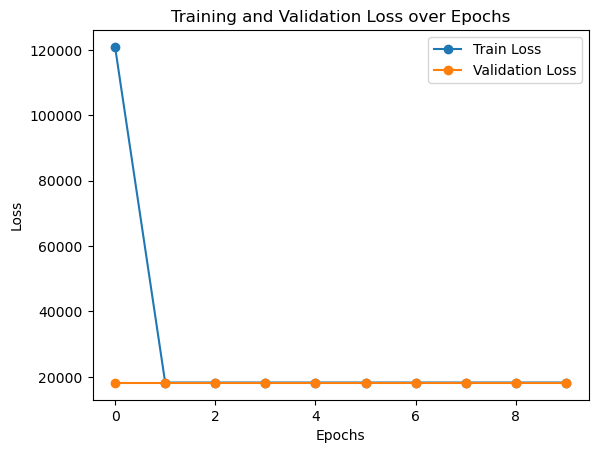

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./csv_files/resnet/test_train.csv')
#Plotting the training loss
plt.plot(df.epoch, df.loss, label='Train Loss', marker='o')

#Plotting the validation loss
plt.plot(df.epoch, df.val_loss, label='Validation Loss', marker='o')

#Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

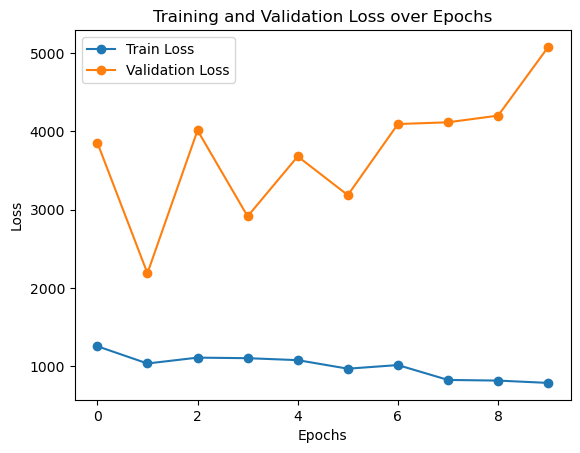

In [40]:

df = pd.read_csv('./csv_files/resnet/test_train_1.csv')
#Plotting the training loss
plt.plot(df.epoch, df.loss, label='Train Loss', marker='o')

#Plotting the validation loss
plt.plot(df.epoch, df.val_loss, label='Validation Loss', marker='o')

#Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

In [41]:
prediction = model.predict((metacarpal_image_data[500], carpal_image_data[500], gender_train[500]))

ValueError: Failed to find data adapter that can handle input: (<class 'tuple'> containing values of types {"<class 'numpy.int32'>", "<class 'numpy.ndarray'>"}), <class 'NoneType'>

In [44]:
carpal_conv_layer = model.get_layer('carpal_conv5_block3_out')
metacarpal_conv_layer = model.get_layer('metacarpal_conv5_block3_out')

In [ ]:
from keras.dtensor import optimizers

carpal_conv_layer.trainable = True
for i, layer in enumerate(carpal_conv_layer.layers):
    if i < 115:
        layer.trainable = False
    else:
        layer.trainable = True

# Lower learning rate
carpal_optim = optimizers.Adam(
    lr = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    decay = 0
)

In [59]:
from keras.optimizers import Adam

def fine_tune(model, lr, metric):
    # Unfreeze last 2 convolutional blocks of base model
    carpal_conv_layer = model.get_layer('carpal_conv5_block3_out')
    metacarpal_conv_layer = model.get_layer('metacarpal_conv5_block3_out')
    carpal_conv_layer.trainable = True
    metacarpal_conv_layer.trainable = True

    # Lower learning rate
    optim = Adam(
        learning_rate = lr,
        beta_1 = 0.9,
        beta_2 = 0.999,
    )

    # Re-compile model
    model.compile(loss = 'mean_absolute_error', optimizer = optim, metrics = metric)
    return model

In [62]:
history1 = fine_tune(model, 0.001, ['accuracy','mae'])

In [63]:
hist = history1.fit(
    (metacarpal_image_data[:200],carpal_image_data[:200], gender_train[:200]),y_train[:200],
    epochs=10,
    batch_size=32,
    validation_data=((metacarpal_image_data[200:250],carpal_image_data[200:250], gender_train[200:250]), y_train[200:250]),
    callbacks=callbacks_list
)

Epoch 1/10


ResourceExhaustedError: in user code:

    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 695, in apply_gradients
        self._create_all_weights(var_list)
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 959, in _create_all_weights
        self._create_slots(var_list)
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py", line 128, in _create_slots
        self.add_slot(var, "v")
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1050, in add_slot
        weight = tf.Variable(
    File "C:\Users\JARVIS\anaconda3\envs\gpuenv\lib\site-packages\keras\initializers\initializers_v2.py", line 171, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[200705,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Fill]
